In [1]:
# tinygp and non-gaussian likelihoods
# also example of a latent gp model?
# https://tinygp.readthedocs.io/en/stable/tutorials/likelihoods.html

# example

In [2]:
import numpyro
numpyro.set_host_device_count(2)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:


# random = np.random.default_rng(203618)
# x = np.linspace(-3, 3, 20)
# true_log_rate = 2 * np.cos(2 * x)
# y = random.poisson(np.exp(true_log_rate))
# plt.plot(x, y, ".k", label="data")
# plt.plot(x, np.exp(true_log_rate), "C1", label="true rate")
# plt.legend(loc=2)
# plt.xlabel("x")
# _ = plt.ylabel("counts")

In [5]:
import jax
import jax.numpy as jnp
# import numpyro
import numpyro.distributions as dist
from tinygp import kernels, GaussianProcess

jax.config.update("jax_enable_x64", True)


In [6]:


# def model(x, y=None):
#     # The parameters of the GP model
#     mean = numpyro.sample("mean", dist.Normal(0.0, 2.0))
#     sigma = numpyro.sample("sigma", dist.HalfNormal(3.0))
#     rho = numpyro.sample("rho", dist.HalfNormal(10.0))

#     # Set up the kernel and GP objects
#     kernel = sigma**2 * kernels.Matern52(rho)
#     gp = GaussianProcess(kernel, x, diag=1e-5, mean=mean)

#     # This parameter has shape (num_data,) and it encodes our beliefs about
#     # the process rate in each bin
#     log_rate = numpyro.sample("log_rate", gp.numpyro_dist())

#     # Finally, our observation model is Poisson
#     numpyro.sample("obs", dist.Poisson(jnp.exp(log_rate)), obs=y)


# # Run the MCMC
# nuts_kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9)
# mcmc = numpyro.infer.MCMC(
#     nuts_kernel,
#     num_warmup=1000,
#     num_samples=1000,
#     num_chains=2,
#     progress_bar=True,
# )
# rng_key = jax.random.PRNGKey(55873)
# mcmc.run(rng_key, x, y=y)
# samples = mcmc.get_samples()

In [7]:
# q = np.percentile(samples["log_rate"], [5, 25, 50, 75, 95], axis=0)
# plt.plot(x, np.exp(q[2]), color="C0", label="MCMC inferred rate")
# plt.fill_between(x, np.exp(q[0]), np.exp(q[-1]), alpha=0.3, lw=0, color="C0")
# plt.fill_between(x, np.exp(q[1]), np.exp(q[-2]), alpha=0.3, lw=0, color="C0")
# plt.plot(x, np.exp(true_log_rate), "--", color="C1", label="true rate")
# plt.plot(x, y, ".k", label="data")
# plt.legend(loc=2)
# plt.xlabel("x")
# _ = plt.ylabel("counts")

# my take on regression

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [38]:
df = pd.read_csv("/Users/sebastian.khan/Downloads/lidar.csv")
scaler = MinMaxScaler()
x = df['range'].values[:,np.newaxis]
x = scaler.fit_transform(x)[:,0]
y = df['logratio'].values

In [39]:
x = x[::10]
y = y[::10]
y = np.exp(y)

In [40]:
x.shape

(23,)

In [41]:
y.shape

(23,)

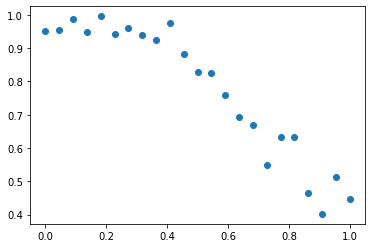

In [42]:
plt.plot(x, y, 'o')

In [43]:

def model(x, y=None):
    # The parameters of the GP model
    mean = numpyro.sample("mean", dist.Normal(0.0, 2.0))
    sigma = numpyro.sample("sigma", dist.HalfNormal(3.0))
    rho = numpyro.sample("rho", dist.HalfNormal(10.0))

    # Set up the kernel and GP objects
    kernel = sigma**2 * kernels.Matern52(rho)
    gp_mean = GaussianProcess(kernel, x, diag=1e-6, mean=mean)
    
    # gp for the noise
    # mean_var = numpyro.sample("mean_var", dist.Normal(0.0, 2.0))
    sigma_var = numpyro.sample("sigma_var", dist.HalfNormal(0.1))
    rho_var = numpyro.sample("rho_var", dist.HalfNormal(10.0))
    kernel_var = sigma_var**2 * kernels.Matern52(rho_var)
    gp_var = GaussianProcess(kernel_var, x, diag=1e-2)

    # This parameter has shape (num_data,) and it encodes our beliefs about
    # the process rate in each bin
    mu = numpyro.sample("mu", gp_mean.numpyro_dist())
    log_noise = numpyro.sample("log_noise", gp_var.numpyro_dist())

    # Finally, our observation model is Normal
    numpyro.sample("obs", dist.Normal(loc=mu, scale=jnp.exp(log_noise)), obs=y)


In [44]:


# Run the MCMC
nuts_kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=3000,
    num_chains=2,
    progress_bar=True,
)


In [45]:
rng_key = jax.random.PRNGKey(55873)
mcmc.run(rng_key, x, y=y)
samples = mcmc.get_samples()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [46]:
samples.keys()

dict_keys(['log_noise', 'mean', 'mu', 'rho', 'rho_var', 'sigma', 'sigma_var'])

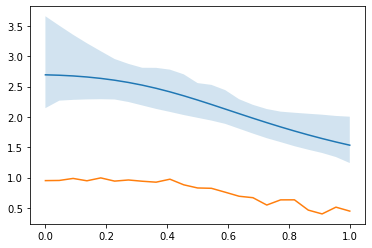

In [64]:
# plt.plot(x, jnp.exp(samples['mu']).T, c='k', alpha=0.1);
plt.plot(x, jnp.exp(samples['mu']).mean(0));
plt.fill_between(x, y1=jnp.exp(samples['mu']).min(0), y2=jnp.exp(samples['mu']).max(0), alpha=0.2);
plt.plot(x, y)

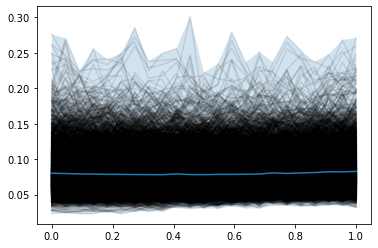

In [66]:
plt.plot(x, jnp.exp(samples['log_noise']).T, c='k', alpha=0.1);
plt.plot(x, jnp.exp(samples['log_noise']).mean(0));
plt.fill_between(x, y1=jnp.exp(samples['log_noise']).min(0), y2=jnp.exp(samples['log_noise']).max(0), alpha=0.2);

In [49]:
import arviz as az

data = az.from_numpyro(mcmc)
az.summary(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
log_noise[0]  -2.578  0.324  -3.186   -1.971      0.014    0.010     536.0   
log_noise[1]  -2.584  0.323  -3.164   -1.961      0.014    0.010     525.0   
log_noise[2]  -2.588  0.317  -3.173   -1.985      0.014    0.010     520.0   
log_noise[3]  -2.591  0.318  -3.141   -1.949      0.014    0.010     522.0   
log_noise[4]  -2.595  0.317  -3.152   -1.968      0.014    0.010     518.0   
log_noise[5]  -2.596  0.317  -3.176   -1.997      0.014    0.010     511.0   
log_noise[6]  -2.598  0.316  -3.157   -1.975      0.014    0.010     519.0   
log_noise[7]  -2.600  0.313  -3.121   -1.952      0.014    0.010     508.0   
log_noise[8]  -2.600  0.312  -3.137   -1.986      0.014    0.010     506.0   
log_noise[9]  -2.584  0.304  -3.129   -1.992      0.014    0.010     518.0   
log_noise[10] -2.598  0.310  -3.132   -1.983      0.014    0.010     513.0   
log_noise[11] -2.598  0.307  -3.113   -1.958      0.014    0.010     517.0   
log_noise[12] -2.593  0.306  -3.165   -2.031      0.013    0.010     523.0   
log_noise[13] -2.593  0.303  -3.118   -1.991      0.013    0.010     522.0   
log_noise[14] -2.589  0.302  -3.123   -2.008      0.013    0.010     513.0   
log_noise[15] -2.586  0.302  -3.148   -2.026      0.013    0.009     532.0   
log_noise[16] -2.562  0.293  -3.091   -2.005      0.013    0.009     525.0   
log_noise[17] -2.574  0.299  -3.088   -1.975      0.013    0.009     540.0   
log_noise[18] -2.563  0.294  -3.066   -1.984      0.013    0.009     559.0   
log_noise[19] -2.558  0.297  -3.090   -1.971      0.013    0.009     555.0   
log_noise[20] -2.545  0.297  -3.080   -1.979      0.013    0.009     568.0   
log_noise[21] -2.547  0.300  -3.067   -1.945      0.013    0.009     563.0   
log_noise[22] -2.541  0.305  -3.097   -1.970      0.013    0.009     596.0   
mean           0.133  1.340  -2.550    2.628      0.050    0.035     707.0   
mu[0]          0.990  0.056   0.891    1.097      0.002    0.001     934.0   
mu[1]          0.988  0.044   0.912    1.074      0.001    0.001    1164.0   
mu[2]          0.984  0.035   0.919    1.049      0.001    0.001    1710.0   
mu[3]          0.978  0.029   0.920    1.030      0.001    0.000    2393.0   
mu[4]          0.969  0.027   0.921    1.020      0.001    0.000    2318.0   
mu[5]          0.957  0.027   0.908    1.008      0.001    0.001    1452.0   
mu[6]          0.943  0.029   0.890    0.998      0.001    0.001     957.0   
mu[7]          0.926  0.030   0.867    0.981      0.001    0.001     763.0   
mu[8]          0.905  0.032   0.843    0.961      0.001    0.001     685.0   
mu[9]          0.881  0.032   0.818    0.936      0.001    0.001     668.0   
mu[10]         0.854  0.031   0.790    0.906      0.001    0.001     708.0   
mu[11]         0.823  0.030   0.762    0.874      0.001    0.001     801.0   
mu[12]         0.791  0.028   0.737    0.842      0.001    0.001     990.0   
mu[13]         0.756  0.027   0.706    0.805      0.001    0.001    1359.0   
mu[14]         0.720  0.026   0.671    0.766      0.001    0.000    1838.0   
mu[15]         0.683  0.026   0.634    0.730      0.001    0.000    1990.0   
mu[16]         0.645  0.026   0.596    0.694      0.001    0.000    1833.0   
mu[17]         0.607  0.028   0.555    0.658      0.001    0.000    1567.0   
mu[18]         0.570  0.030   0.515    0.627      0.001    0.001    1382.0   
mu[19]         0.533  0.032   0.471    0.596      0.001    0.001    1345.0   
mu[20]         0.497  0.037   0.430    0.568      0.001    0.001    1432.0   
mu[21]         0.461  0.043   0.381    0.542      0.001    0.001    1572.0   
mu[22]         0.427  0.051   0.324    0.517      0.001    0.001    1733.0   
rho            3.386  2.355   0.445    7.383      0.104    0.073     413.0   
rho_var        8.961  5.883   0.757   19.741      0.136    0.096    1436.0   
sigma          2.264  1.465   0.205    4.850      0.038    0.027    1135.0   
sigma_var      0.511  0.059   0.400   

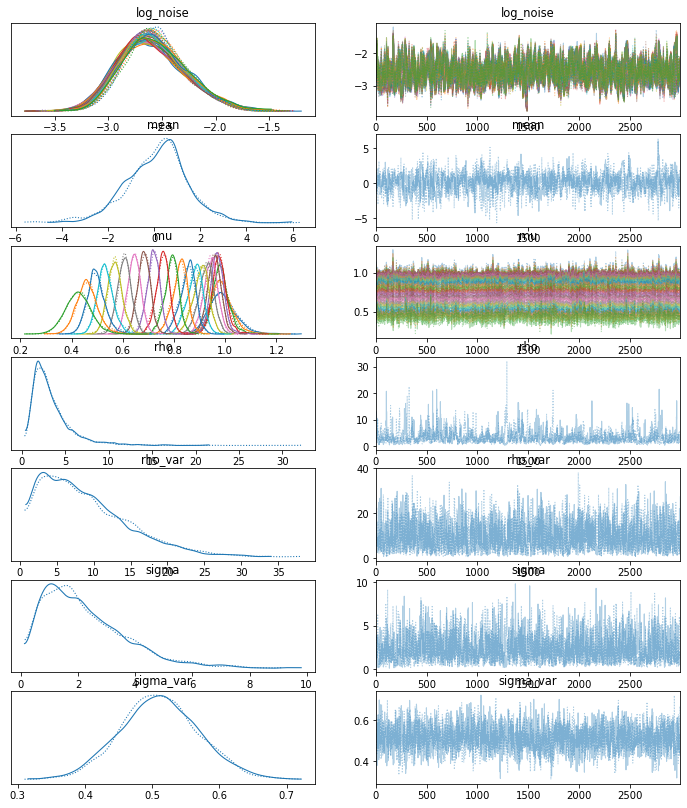

In [56]:
az.plot_trace(data);

In [50]:
prior_pred_samples = numpyro.infer.Predictive(model, num_samples=10)(jax.random.PRNGKey(1), x, y)

In [51]:
prior_pred_samples['obs'].shape

(10, 23)

In [52]:
prior_pred_samples.keys()

dict_keys(['log_noise', 'mean', 'mu', 'obs', 'rho', 'rho_var', 'sigma', 'sigma_var'])

In [53]:
prior_pred_samples['log_noise'].shape

(10, 23)

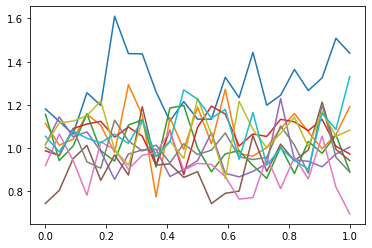

In [54]:
plt.plot(x, jnp.exp(prior_pred_samples['log_noise']).T);